In [67]:
#Import Packages
import pandas as pd
import datetime
import os
import statistics
import json
import matplotlib
from matplotlib import pyplot
from matplotlib import dates
import datetime
import matplotlib.dates as mdates

In [68]:
#Functions to determine distribution
def checkDescending(l):
    flag = 0
    temp = l[:]
    temp.sort(reverse = True)
    if (l == temp):
        flag = 1
    if (flag) :
        return True
    else :
        return False
    
def checkAscending(l):
    flag = 0
    temp = l[:]
    temp.sort()
    if (l == temp):
        flag = 1
    if (flag) :
        return True
    else :
        return False

    
def checkRandom(l):
    if max(l)-min(l)<=10:
        return True
    else:
        return False
    

In [69]:
#Pre-processing
data = pd.read_csv("KogVoi.csv") #Delta Centre Electricity Consumption Dataset
data = data.drop(['tags'], axis = 1)
data['time'] = pd.to_datetime(data['time'])
data['time'] = data['time'].dt.strftime('%Y-%m-%d %H:%M:%S')
data = data[data.host != 11029]
data = data[data.time != "1970-01-01 00:26:40"]
data = data.drop_duplicates(subset=['time'], keep='first')
x = data['time'].values.tolist()
y = data['value'].values.tolist()

In [70]:
#Selecting Interval
date_list = [i for i in x if i>='2020-10-12 00:00:00' and i<'2020-10-13 00:00:00'] 
values = []
index = []
index.clear()
values.clear()

for i in range(len(x)):
    if x[i]>='2020-10-12 00:00:00' and x[i]<'2020-10-13 00:00:00': 
        index.append(i)

for i in index:
    values.append(y[i])

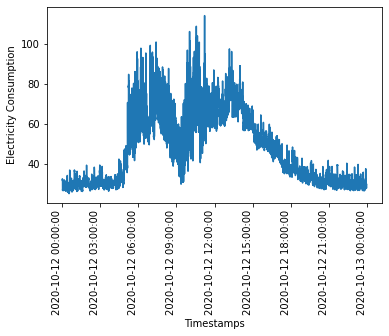

<Figure size 720x360 with 0 Axes>

In [71]:
#Plotting Selected Interval
converted_dates = list(map(datetime.datetime.strptime,date_list, len(date_list)*['%Y-%m-%d %H:%M:%S']))
x_axis = converted_dates
formatter = dates.DateFormatter('%Y-%m-%d %H:%M:%S')
y_axis = values
pyplot.plot( x_axis, y_axis, '-' )
ax = pyplot.gcf().axes[0] 
ax.xaxis.set_major_formatter(formatter)
pyplot.gcf().autofmt_xdate(rotation=90)
hours = mdates.HourLocator(interval = 1)
#h_fmt = mdates.DateFormatter('%H:%M:%S')
#ax.xaxis.set_major_locator(hours)
#ax.xaxis.set_major_formatter(h_fmt)
pyplot.xlabel("Timestamps")
pyplot.ylabel("Electricity Consumption")
width1 = 10
height1 = 5
width_height_1 = (width1, height1)
pyplot.figure(figsize=width_height_1)
pyplot.show()


In [73]:
#Diving Single Day into 1-hour Intervals
ind = []
values1 = []
average = []
diff = []
distribution = ''
for i in range(0,24):
    values1.clear()
    ind.clear()
    diff.clear()
    T = '2020-09-26 ' + str(i).zfill(2)
    for j in range(len(x)):
        if x[j].startswith(T):
            ind.append(j)
    for k in ind:
        values1.append(y[k])
        
    #Determining Distribution of Data for Each Interval
    if checkAscending(values1):
        r1 = min(values1)
        r2 = max(values1)
        d=[]
        for i in range(len(values1)-1):
            d.append(values1[i+1]-values1[i])
        slope = sum(d)/len(d)
        distribution = '{"type":"double_increment","min":'+str(r1)+',"max":'+str(r2)+',"slope":'+str(slope)+'}'
    elif checkDescending(values1):
        r1 = min(values1)
        r2 = max(values1)
        d=[]
        for i in range(len(values1)-1):
            d.append(values1[i]-values1[i+1])
        slope = sum(d)/len(d)
        distribution = '{"type":"double_decrement","min":'+str(r1)+',"max":'+str(r2)+',"slope":'+str(slope)+'}'
    elif checkRandom(values1):
        r1 = min(values1)
        r2 = max(values1)
        distribution = '{"type":"double_uniform","min":'+str(r1)+',"max":'+str(r2)+'}'
    else:
        mean = sum(values1) / len(values1)
        average.append(mean)
        for l in values1:
            diff.append(l-mean)
        distribution = '{"type":"double_mean","mean":'+str(mean)+',"values":'+str(diff)+'"anomaly":10}'
        
        
        
        
        
    #Creation of Device Configuration Files   
    interval = round(3600000/len(values1))
    save_path = '~/configurations'
    file_name = "devices"+str(i)+".json"
    filename = os.path.join(save_path, file_name)
    completeName = os.path.join(save_path, file_name)
    default_anomaly = 10.00
    data = [
        {
            "type":"simple",
            "uuid":"dev%04d",
            "topic":"device/{$uuid}",
            "sampling":{"type":"fixed", "interval":interval},
            "copy":2,
            "sensors":[
                {"type":"dev.timestamp",    "name":"ts"},
                {"type":"dev.uuid",         "name":"uuid"},
                distribution
            ]
        }
    ]
    with open(filename, 'w') as f:
        json.dump(data, f)



    
